The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. We will experiment with the continouse version in this one.


![Mountain Car](https://gymnasium.farama.org/_images/mountain_car_continuous.gif)

The observation is a ndarray with shape (2,) where the elements correspond to the position of the car along the x-axis and the velocity of the car.

The action is a ndarray with shape (1,), representing the directional force applied on the car. The action is clipped in the range [-1,1] and multiplied by a power of 0.0015.

A negative reward of $-0.1 * action^2$ is received at each timestep to penalise for taking actions of large magnitude. If the mountain car reaches the goal then a positive reward of +100 is added to the negative reward for that timestep.

You can read more the MountainCar Continous environment [here](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/)

## Continous Action Spaces

It's conceptually the same as for discrete action spaces. In discrete action spaces you have a discrete distribution like the categorical distribution and you calculate the log pi probabilities using its mass function. In continuous action spaces you use a continuous distribution like the Gaussian distribution and calculate the log pi “probabilities” using its density function. Everything else is the same.

So instead of having network that outputs the parameters for a categorical distribution, you have a network that outputs parameters for (usually) a Gaussian distribution (i.e. the mean and standard deviation)

But, usually we just output the mean using a neural network, and have a separate set of learnable parameters for std (in log space) for each action. For example, if we 3 continous actions then we will have a neural network which will output the means for these actions and then separate 3 parameters which will represent the log std of these actions. We still learn these log std but they are not dependent on state. We just have a log std for each action.

Other approaches for std include:
- Having a std as output of neural network just as the mean.
- Initializing some std for all actions at start and then steadily decrease if using a std_decay hyperparameter as the training progresses.


You can use any appraoch you like.



## DDPG


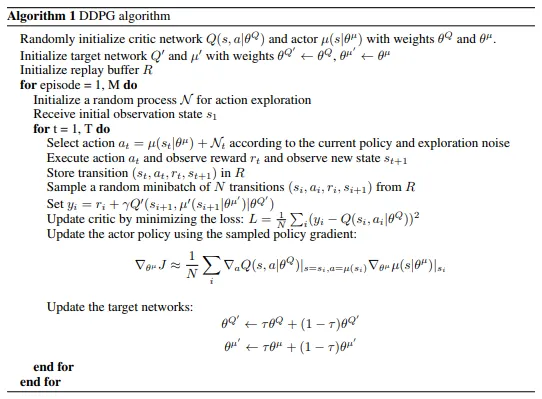

Continuous Control With Deep Reinforcement Learning” (Lillicrap et al, 2015)

It is worth mentioning that I used the ideas presented in the commnet in this forum:
https://ai.stackexchange.com/questions/22945/ddpg-doesnt-converge-for-mountaincarcontinuous-v0-gym-environment

In [60]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import deque, namedtuple

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical
from torch.distributions import Normal

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [62]:
env = gym.make('MountainCarContinuous-v0')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [70]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(state_size, 32)
        self.l2 = nn.Linear(32, 32)
        self.l3 = nn.Linear(32, action_size)
        self.l1.weight.data.normal_(0, 1e-1)
        self.l2.weight.data.normal_(0, 1e-1)
        self.l3.weight.data.normal_(0, 1e-2)


    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        return F.tanh(self.l3(x))

In [71]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.l1 = nn.Linear(state_size + action_size, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 1)
        self.l1.weight.data.normal_(0, 1e-1)
        self.l2.weight.data.normal_(0, 1e-1)
        self.l3.weight.data.normal_(0, 1e-2)


    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

In [72]:
Transition = namedtuple('Transition',
                        ('state', 'action','reward', 'next_state', 'done'))

class Memory(object):

    def __init__(self, capacity,batch_size):
        self.memory = deque([], maxlen=capacity)
        self.batch_size=batch_size

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self):
      transitions = random.sample(self.memory, self.batch_size)
      return  Transition(*zip(*transitions))

    def __len__(self):
        return len(self.memory)

In [76]:
MEM_SIZE = int(1e6)
BS = 64
GAMMA = 0.99
TAU = 1e-3
EPISODES = 100

In [77]:
class DDPG_TRAINER:
    def __init__(self, state_size, action_size, tau):
        self.memory = Memory(MEM_SIZE, BS)
        self.tau = tau
        self.std = 1
        self.actor = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optim = optim.Adam(self.actor.parameters(), lr=1e-3)
        self.critic = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_optim = optim.Adam(self.critic.parameters(), lr=1e-3)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)

    def update_std(self):
        self.std = max(self.std - 0.01, 0.1)

    def get_action(self, state, add_N = True):
        state =  torch.tensor(state).to(device).float()
        action = self.actor(state).cpu().data.numpy()
        if add_N:
            action = action + np.random.normal(0, self.std)

        action[0] = np.clip(action[0],-1,1)
        return action

    def update(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
        if len(self.memory) >= self.memory.batch_size:
            state, action, reward, next_state, done = self.memory.sample()

            state = torch.tensor(state).to(device).float()
            next_state = torch.tensor(next_state).to(device).float()
            reward = torch.tensor(reward).to(device).float()
            action = torch.tensor(action).to(device)
            done = torch.tensor(done).to(device).int()

            #critic
            target_action = self.actor_target(next_state)

            y = self.critic_target(next_state, target_action).detach()
            target_q = reward.unsqueeze(1) + (GAMMA*y*((1-done).unsqueeze(1)))
            critic_loss = F.mse_loss(self.critic(state, action), target_q)
            self.critic_optim.zero_grad()
            critic_loss.backward()
            self.critic_optim.step()

            #actor

            action_mu = self.actor(state)
            actor_loss = -self.critic(state, action_mu).mean()
            self.actor_optim.zero_grad()
            actor_loss.backward()
            self.actor_optim.step()

            for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
                target_param.data.copy_(TAU*param.data + (1-TAU)*target_param.data)
            for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
                target_param.data.copy_(TAU*param.data + (1-TAU)*target_param.data)



In [78]:
action_size = env.action_space.shape[0]
print(f'size of eche action = {action_size}')
state_size = env.observation_space.shape[0]
print(f'size of state = {state_size}')

size of eche action = 1
size of state = 2


In [79]:
trainer = DDPG_TRAINER(state_size = state_size, action_size = action_size, tau = TAU)

reward_list = []
for i in range(EPISODES):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = trainer.get_action(state)
        next_state, reward, done, _ = env.step(action)
        trainer.update(state, action, reward, next_state, done)
        total_reward +=reward
        state = next_state

    reward_list.append(total_reward)
    trainer.update_std()

    print(f"episode: {i+1}, current reward: {total_reward}")



episode: 1, current reward: -51.8913128666249
episode: 2, current reward: 70.4805655238607
episode: 3, current reward: -54.48582959917711
episode: 4, current reward: -48.618909043633515
episode: 5, current reward: -51.42124755658203
episode: 6, current reward: -55.075949595319095
episode: 7, current reward: -49.9731335136144
episode: 8, current reward: -50.541180841907995
episode: 9, current reward: -48.40612482300528
episode: 10, current reward: -46.956026796472955
episode: 11, current reward: -46.59940203546319
episode: 12, current reward: -45.29246200493948
episode: 13, current reward: -47.955048298400555
episode: 14, current reward: -45.72014762559381
episode: 15, current reward: -46.21002752071942
episode: 16, current reward: -47.2082070418753
episode: 17, current reward: -45.73864957101302
episode: 18, current reward: -46.73297557025204
episode: 19, current reward: -44.59659085512318
episode: 20, current reward: -44.64275278364562
episode: 21, current reward: -44.01740094938682
e

NEW METHOD DDPG

In [80]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [85]:
os.makedirs("video", exist_ok=True)

def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

def show_video_of_model(env_name):
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format(env_name))
    state = env.reset()
    done = False
    score = 0
    for t in range(500):
        vid.capture_frame()
        action= trainer.get_action(state,False)
        next_state, reward, done, info = env.step(action)
        state = next_state
        score = reward
        if done:
            break
    print(score)
    vid.close()
    env.close()

In [86]:
show_video_of_model('MountainCarContinuous-v0')

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCarContinuous-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


99.9


In [87]:
show_video('MountainCarContinuous-v0')